## Overview

In [41]:
import yfinance as yf
import polars as pl
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# Configue Polars
pl.Config.set_tbl_width_chars(120)
pl.Config.set_tbl_cols(10)
print("Polars display configuration set.")

Polars display configuration set.


In [43]:
ticker_symbol = "SPY"
start_date = "2015-01-01" 
end_date = datetime.now().strftime("%Y-%m-%d")

In [44]:
asset = yf.Ticker(ticker_symbol)
print(asset)

hist_data_yf = asset.history(start=start_date, end=end_date, interval="1d")
# print(hist_data_yf.head())
hist_data_yf = hist_data_yf.reset_index()
hist_data_pl = pl.from_pandas(hist_data_yf)

print(f"Historical data for {ticker_symbol} from {start_date} to {end_date}:")
print(hist_data_pl.head())
print(f"\nShape of the data (rows, columns): {hist_data_pl.shape}")

yfinance.Ticker object <SPY>
Historical data for SPY from 2015-01-01 to 2025-06-03:
shape: (5, 9)
┌────────────────┬────────────┬────────────┬────────────┬────────────┬───────────┬───────────┬────────┬────────────────┐
│ Date           ┆ Open       ┆ High       ┆ Low        ┆ Close      ┆ Volume    ┆ Dividends ┆ Stock  ┆ Capital Gains  │
│ ---            ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---       ┆ ---       ┆ Splits ┆ ---            │
│ datetime[ns,   ┆ f64        ┆ f64        ┆ f64        ┆ f64        ┆ i64       ┆ f64       ┆ ---    ┆ f64            │
│ America/New_Yo ┆            ┆            ┆            ┆            ┆           ┆           ┆ f64    ┆                │
│ rk]            ┆            ┆            ┆            ┆            ┆           ┆           ┆        ┆                │
╞════════════════╪════════════╪════════════╪════════════╪════════════╪═══════════╪═══════════╪════════╪════════════════╡
│ 2015-01-02     ┆ 172.870989 ┆ 173.289806 ┆ 171.028183

In [45]:
hist_data_pl = hist_data_pl.with_columns(
    pl.col("Date").cast(pl.Date)
)
print("Converted 'Date' column from Datetime to Date type")
print(hist_data_pl.head(5))

print("\n==============\n")
print(hist_data_pl.tail(5))

Converted 'Date' column from Datetime to Date type
shape: (5, 9)
┌────────────┬────────────┬────────────┬────────────┬────────────┬───────────┬───────────┬──────────────┬─────────┐
│ Date       ┆ Open       ┆ High       ┆ Low        ┆ Close      ┆ Volume    ┆ Dividends ┆ Stock Splits ┆ Capital │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---       ┆ ---       ┆ ---          ┆ Gains   │
│ date       ┆ f64        ┆ f64        ┆ f64        ┆ f64        ┆ i64       ┆ f64       ┆ f64          ┆ ---     │
│            ┆            ┆            ┆            ┆            ┆           ┆           ┆              ┆ f64     │
╞════════════╪════════════╪════════════╪════════════╪════════════╪═══════════╪═══════════╪══════════════╪═════════╡
│ 2015-01-02 ┆ 172.870989 ┆ 173.289806 ┆ 171.028183 ┆ 172.075226 ┆ 121465900 ┆ 0.0       ┆ 0.0          ┆ 0.0     │
│ 2015-01-05 ┆ 171.019869 ┆ 171.187393 ┆ 168.657746 ┆ 168.967667 ┆ 169632600 ┆ 0.0       ┆ 0.0          ┆ 0.0     │
│ 2015-

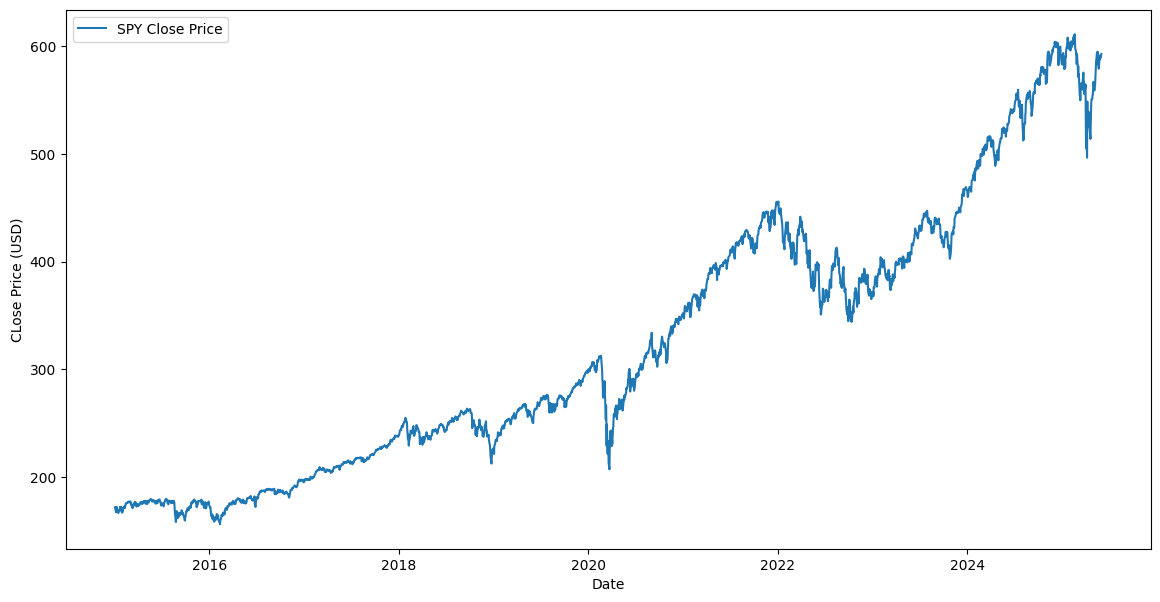

In [46]:
plt.figure(figsize=(14,7))
plt.plot(hist_data_pl["Date"], hist_data_pl["Close"], label=f"{ticker_symbol} Close Price")
plt.xlabel("Date")
plt.ylabel("CLose Price (USD)")
plt.legend()
plt.show()

In [47]:
hist_data_pl = hist_data_pl.with_columns(
    pl.col("Close").pct_change().alias("Daily_Return")
)

print(hist_data_pl.get_column("Daily_Return").drop_nulls().describe())

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 2618.0    │
│ null_count ┆ 0.0       │
│ mean       ┆ 0.000538  │
│ std        ┆ 0.011407  │
│ min        ┆ -0.109424 │
│ 25%        ┆ -0.003725 │
│ 50%        ┆ 0.000602  │
│ 75%        ┆ 0.005963  │
│ max        ┆ 0.105019  │
└────────────┴───────────┘


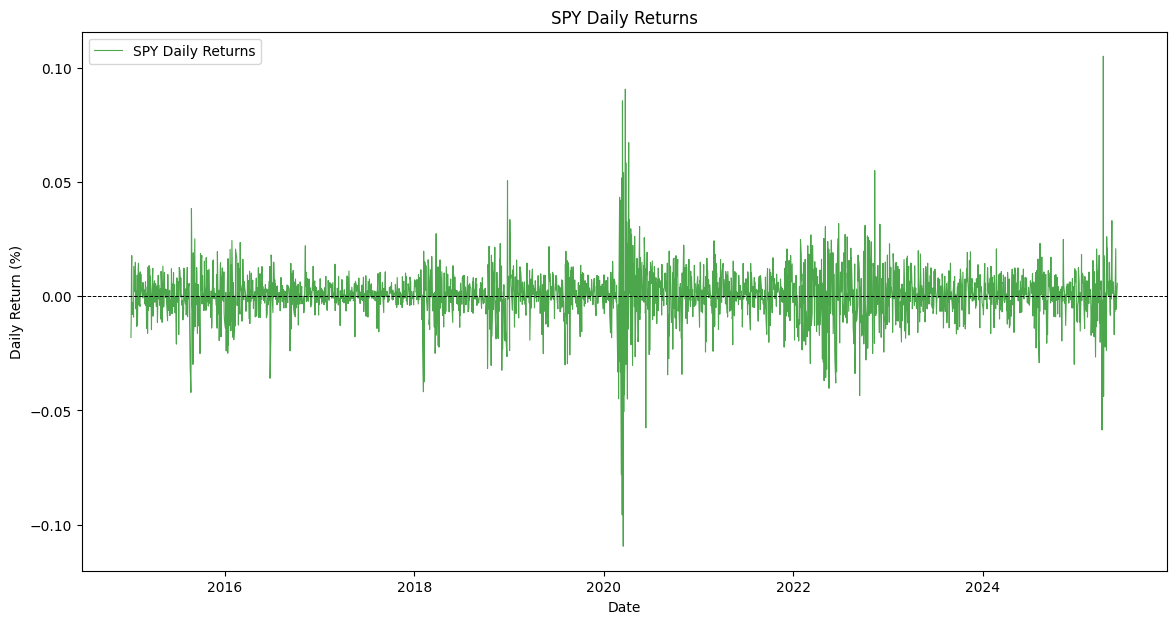

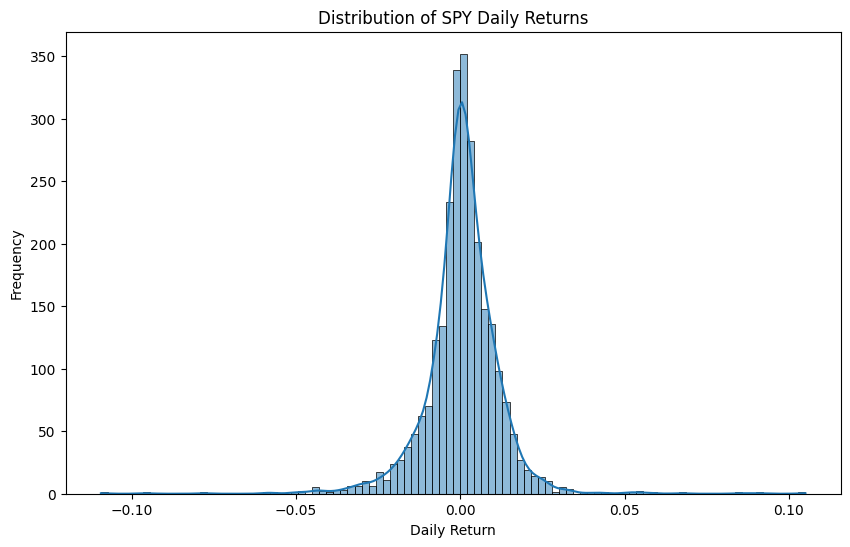

In [48]:
plt.figure(figsize=(14, 7))
plt.plot(hist_data_pl['Date'], hist_data_pl['Daily_Return'], label=f'{ticker_symbol} Daily Returns', color='green', alpha=0.7, linewidth=0.8)
plt.title(f'{ticker_symbol} Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)') # Values are decimal, but represent percentage
plt.axhline(0, color='black', linestyle='--', linewidth=0.7) # Add a horizontal line at zero
plt.legend()
plt.show()

# Optional: Plot a histogram of daily returns to see their distribution
plt.figure(figsize=(10, 6))
sns.histplot(hist_data_pl['Daily_Return'].drop_nulls(), bins=100, kde=True)
plt.title(f'Distribution of {ticker_symbol} Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

In [54]:
## Simulation Parameters and DataFrame Preparation
INVESTMENT_AMOUNT_PER_INTERVAL = 100
SIMULATION_MONTHS = 24

base_simulation_df = hist_data_pl.sort("Date").clone()

max_date_scalar = base_simulation_df.get_column("Date").max()
print(f"Max date: {max_date_scalar}")
simulation_start_date_scalar = pl.select(
    pl.lit(max_date_scalar).dt.offset_by(f"-{SIMULATION_MONTHS}mo")
).item()

simulation_df_filtered = base_simulation_df.filter(
    (pl.col("Date") >= simulation_start_date_scalar) & (pl.col("Date") <= max_date_scalar)
)

actual_simulation_start_date = simulation_df_filtered.get_column("Date").min()
actual_simulation_end_date = simulation_df_filtered.get_column("Date").max()

print(f"Investment amount per interval: ${INVESTMENT_AMOUNT_PER_INTERVAL}")
print(f"Requested simulation period: {SIMULATION_MONTHS} months.")
print(f"Calculated simulation start date (scalar): {simulation_start_date_scalar.strftime('%Y-%m-%d')}")
print(f"Data filtered for simulation from: {actual_simulation_start_date.strftime('%Y-%m-%d')} to {actual_simulation_end_date.strftime('%Y-%m-%d')}")

if simulation_df_filtered.is_empty():
    print("Warning: The filtered simulation DataFrame is empty! Adjust SIMULATION_MONTHS or check data.")
else:
    print(f"Shape of filtered data: {simulation_df_filtered.shape}")
actual_simulation_end_date = simulation_df_filtered.get_column("Date").max()

Max date: 2025-06-02
Investment amount per interval: $100
Requested simulation period: 24 months.
Calculated simulation start date (scalar): 2023-06-02
Data filtered for simulation from: 2023-06-02 to 2025-06-02
Shape of filtered data: (501, 10)


### Strategy C - 1st Trading Day of Month (Revised for Time Window)

In [ ]:
if not simulation_df_filtered.is_empty(): # Proceed only if there's data for the period
    # Add year and month columns to help identify the first trading day of each month
    # USE THE FILTERED DATAFRAME
    strategy_c_df = simulation_df_filtered.with_columns([
        pl.col("Date").dt.year().alias("Year"),
        pl.col("Date").dt.month().alias("Month")
    ])

    # Group by Year and Month, then take the first date in each group
    investment_dates_c = strategy_c_df.group_by(["Year", "Month"], maintain_order=True).agg(
        pl.col("Date").first().alias("Investment_Date")
    ).sort("Investment_Date").get_column("Investment_Date")

    print(f"Strategy C - First 5 investment dates within the filtered period: {investment_dates_c.head(5)}")
    print(f"Strategy C - Last 5 investment dates within the filtered period: {investment_dates_c.tail(5)}")


    # --- Simulation for Strategy C ---
    total_shares_c = 0.0
    cash_invested_c = 0.0

    for date in investment_dates_c:
        # Get the data for the investment day from the FILTERED DataFrame
        day_data = simulation_df_filtered.filter(pl.col("Date") == date)
        if not day_data.is_empty():
            close_price = day_data.get_column("Close")[0]
            shares_bought = INVESTMENT_AMOUNT_PER_INTERVAL / close_price
            total_shares_c += shares_bought
            cash_invested_c += INVESTMENT_AMOUNT_PER_INTERVAL
    
    # Calculate final portfolio value for Strategy C
    # USE THE LAST PRICE FROM THE FILTERED DATAFRAME
    last_price_filtered_period = simulation_df_filtered.get_column("Close")[-1] 
    final_portfolio_value_c = total_shares_c * last_price_filtered_period

    print(f"\n--- Strategy C Results (for {SIMULATION_MONTHS} months period) ---")
    print(f"Total Cash Invested: ${cash_invested_c:,.2f}")
    print(f"Total Shares Acquired: {total_shares_c:.4f}")
    print(f"Last Close Price ({simulation_df_filtered.get_column('Date')[-1].strftime('%Y-%m-%d')}): ${last_price_filtered_period:,.2f}")
    print(f"Final Portfolio Value: ${final_portfolio_value_c:,.2f}")
    profit_c = final_portfolio_value_c - cash_invested_c
    print(f"Total Profit/Loss: ${profit_c:,.2f}")
    return_c = (profit_c / cash_invested_c) * 100 if cash_invested_c > 0 else 0
    print(f"Total Return: {return_c:.2f}%")
else:
    print("Skipping Strategy C simulation as the filtered data period is empty.")

Strategy C - First 5 investment dates within the filtered period: shape: (5,)
Series: 'Investment_Date' [date]
[
	2023-06-02
	2023-07-03
	2023-08-01
	2023-09-01
	2023-10-02
]
Strategy C - Last 5 investment dates within the filtered period: shape: (5,)
Series: 'Investment_Date' [date]
[
	2025-02-03
	2025-03-03
	2025-04-01
	2025-05-01
	2025-06-02
]

--- Strategy C Results (for 24 months period) ---
Total Cash Invested: $2,500.00
Total Shares Acquired: 4.9440
Last Close Price (2025-06-02): $592.71
Final Portfolio Value: $2,930.33
Total Profit/Loss: $430.33
Total Return: 17.21%
